In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import os
print('setup is complete')

setup is complete


In [4]:
test_dataset = pd.read_csv("../input/digit-recognizer/test.csv")
train_dataset = pd.read_csv("../input/digit-recognizer/train.csv")
print('datasets are ready')

datasets are ready


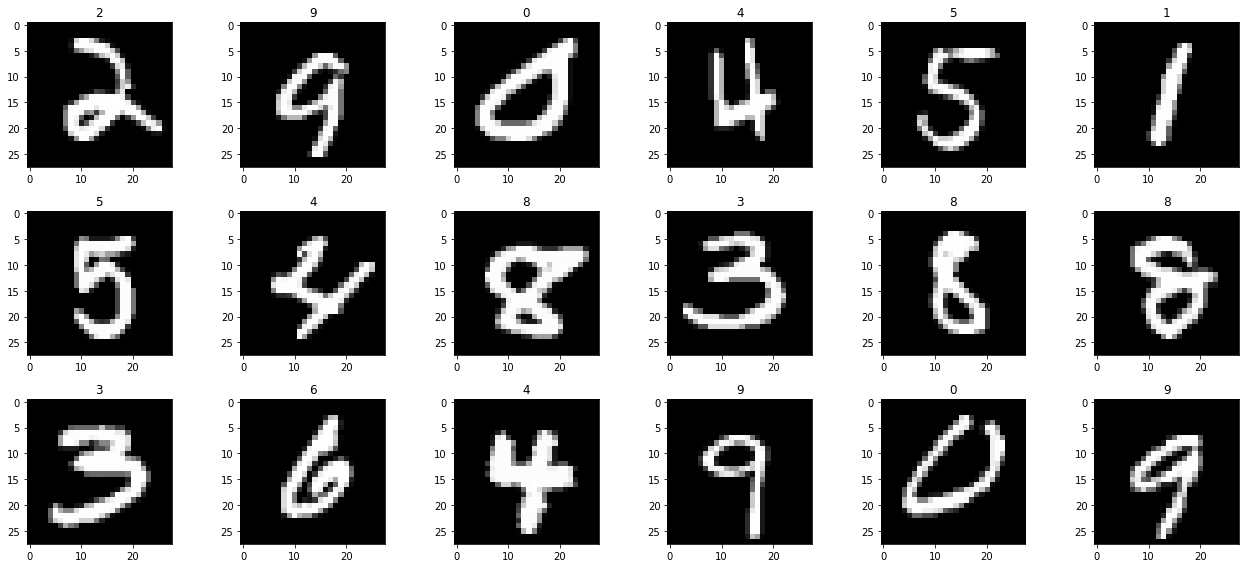

In [6]:
plt.figure(figsize=(18, 8))
sample_image = train_dataset.sample(18).reset_index(drop=True)
for index, row in sample_image.iterrows():
    label = row['label']
    image_pixels = row.drop('label')
    plt.subplot(3, 6, index+1)
    plt.imshow(image_pixels.values.reshape(28,28), cmap=plt.cm.gray)
    plt.title(label)
plt.tight_layout()

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x = train_dataset.drop(columns=['label']).values.reshape(train_dataset.shape[0],28,28,1)
y = to_categorical(train_dataset['label'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [12]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=32
train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_datagen.fit(x_train)
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
train_datagen.fit(x_test)
validation_generator = validation_datagen.flow(
    x_test,
    y_test
    
)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                46090     
Total params: 65,194
Trainable params: 65,194
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [18]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=len(x_train) // batch_size, 
    validation_data=validation_generator,
    validation_steps=len(x_test) // batch_size,
    epochs=150,
    callbacks=callbacks
)

Epoch 1/150
1181/1181 [==============================] - 18s 16ms/step - loss: 0.2275 - accuracy: 0.9327 - val_loss: 0.0531 - val_accuracy: 0.9752

Epoch 00001: val_loss improved from inf to 0.05314, saving model to model.h5
Epoch 2/150
1181/1181 [==============================] - 17s 14ms/step - loss: 0.1485 - accuracy: 0.9557 - val_loss: 0.0119 - val_accuracy: 0.9801

Epoch 00002: val_loss improved from 0.05314 to 0.01186, saving model to model.h5
Epoch 3/150
1181/1181 [==============================] - 17s 14ms/step - loss: 0.1158 - accuracy: 0.9654 - val_loss: 0.0091 - val_accuracy: 0.9856

Epoch 00003: val_loss improved from 0.01186 to 0.00906, saving model to model.h5
Epoch 4/150
1181/1181 [==============================] - 18s 15ms/step - loss: 0.1045 - accuracy: 0.9693 - val_loss: 0.0875 - val_accuracy: 0.9846

Epoch 00004: val_loss did not improve from 0.00906
Epoch 5/150
1181/1181 [==============================] - 18s 15ms/step - loss: 0.0995 - accuracy: 0.9711 - val_loss: 0

In [21]:
test_digit_data = test_dataset.values.reshape(test_dataset.shape[0],28,28,1).astype("float32") / 255
predictions = model.predict(test_digit_data)
results = np.argmax(predictions, axis = 1) 

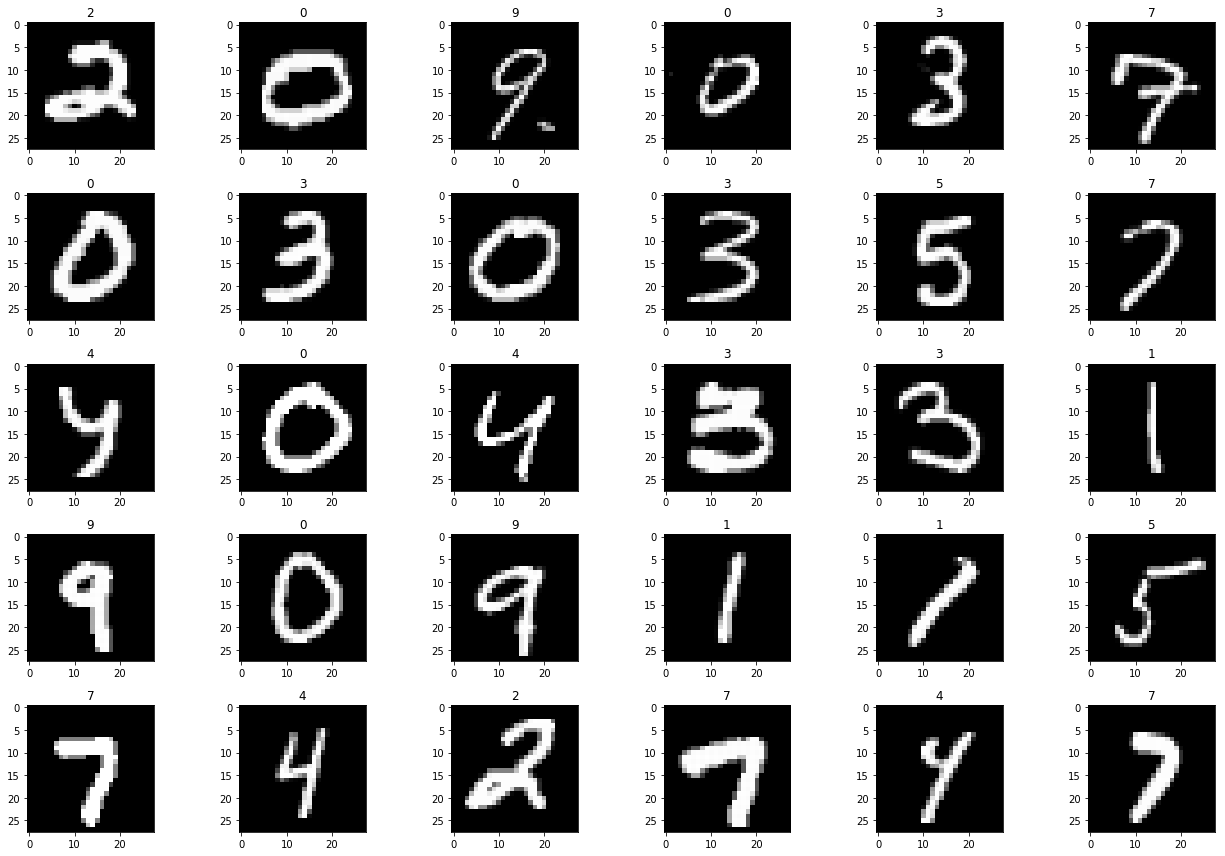

In [24]:
plt.figure(figsize=(18, 12))
sample_test = test_dataset.head(30)
for index, image_pixels in sample_test.iterrows():
    label = results[index]
    plt.subplot(5, 6, index+1)
    plt.imshow(image_pixels.values.reshape(28,28), cmap=plt.cm.gray)
    plt.title(label)
plt.tight_layout()